In [22]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
import os
import sklearn 
import seaborn as sns
model_pred = keras.models.load_model('sky_status_model.h5')

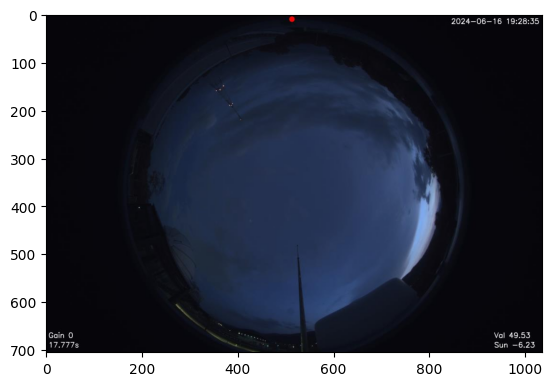

In [257]:
image_path = r'All_sky_camera_Astropark_Chaingmai\2024-06-16\638541377181644415.png'
mask_path = r'mask_delete_5.png'

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)

masked = cv2.bitwise_and(image,image,mask=mask)

plt.imshow(image)

44.933808750270735


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10368\2712184731.py:4: RuntimeWarning: invalid value encountered in divide
  ratio = (R/B)*np.mean(crop_whole)/8
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10368\2712184731.py:12: RuntimeWarning: invalid value encountered in divide
  ratio = (R/B)*np.mean(crop_whole)/8


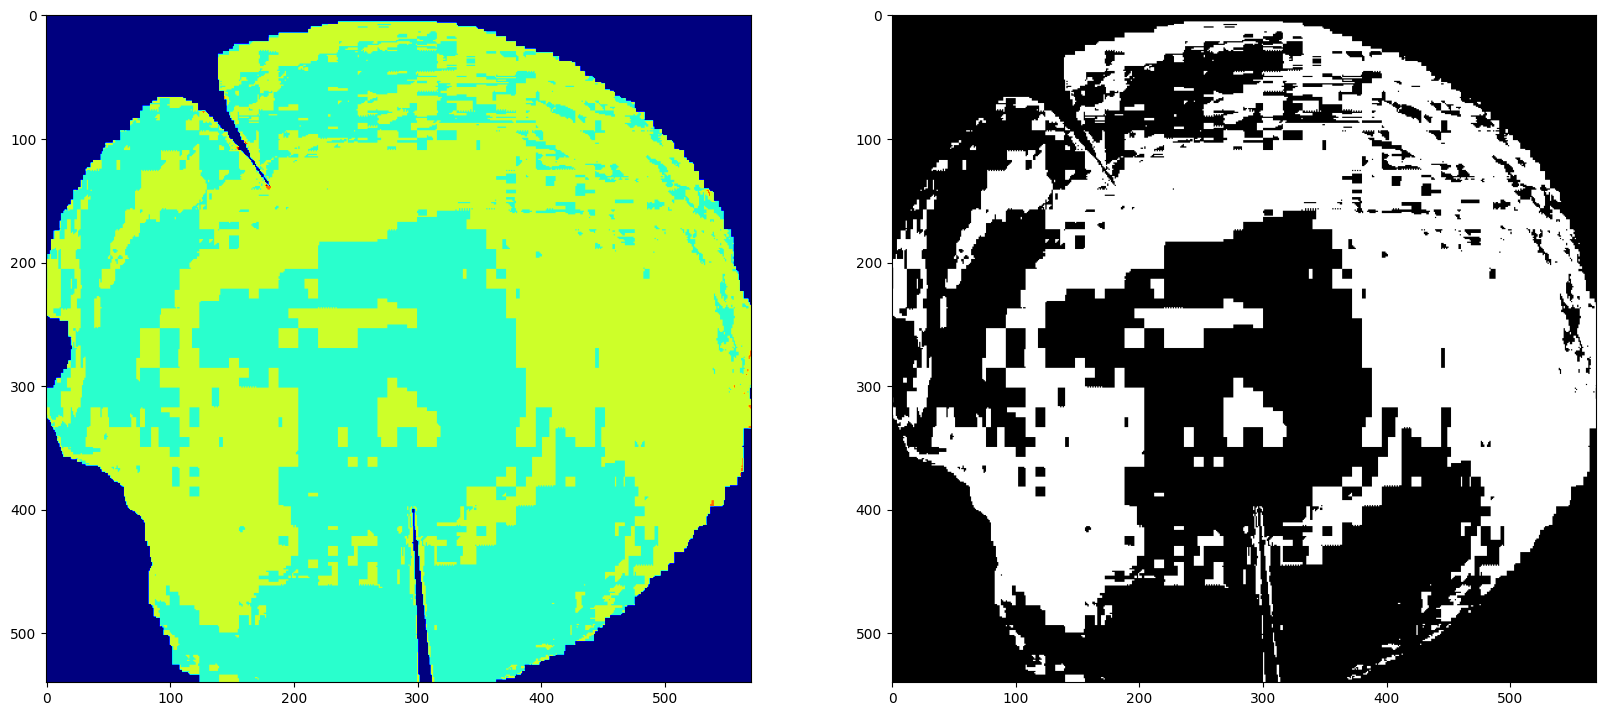

In [258]:
crop_whole = masked[(int(image.shape[0]/2)-270):int((image.shape[0]/2)+270),int((image.shape[1]/2)-290):int((image.shape[1]/2)+280)]
R,G,B = cv2.split(crop_whole)
if np.mean(crop_whole) <= 70:
    ratio = (R/B)*np.mean(crop_whole)/8
    ratio_1 = cv2.convertScaleAbs(ratio)
    _,final_mask = cv2.threshold(ratio_1, np.mean(crop_whole)/10, 255, cv2.THRESH_BINARY)
if np.mean(crop_whole) > 70:
    ratio = (R/B)*np.mean(crop_whole)/10
    ratio_1 = cv2.convertScaleAbs(ratio)
    _,final_mask = cv2.threshold(ratio_1, np.mean(crop_whole)/20, 255, cv2.THRESH_BINARY)
if np.mean(crop_whole) < 45:
    ratio = (R/B)*np.mean(crop_whole)/8
    ratio_1 = cv2.convertScaleAbs(ratio)
    _,final_mask = cv2.threshold(ratio_1, np.mean(crop_whole)/16, 255, cv2.THRESH_BINARY)    

print(np.mean(crop_whole))
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(ratio_1,cmap='jet')
plt.subplot(1,2,2)
plt.imshow(final_mask,cmap='gray')

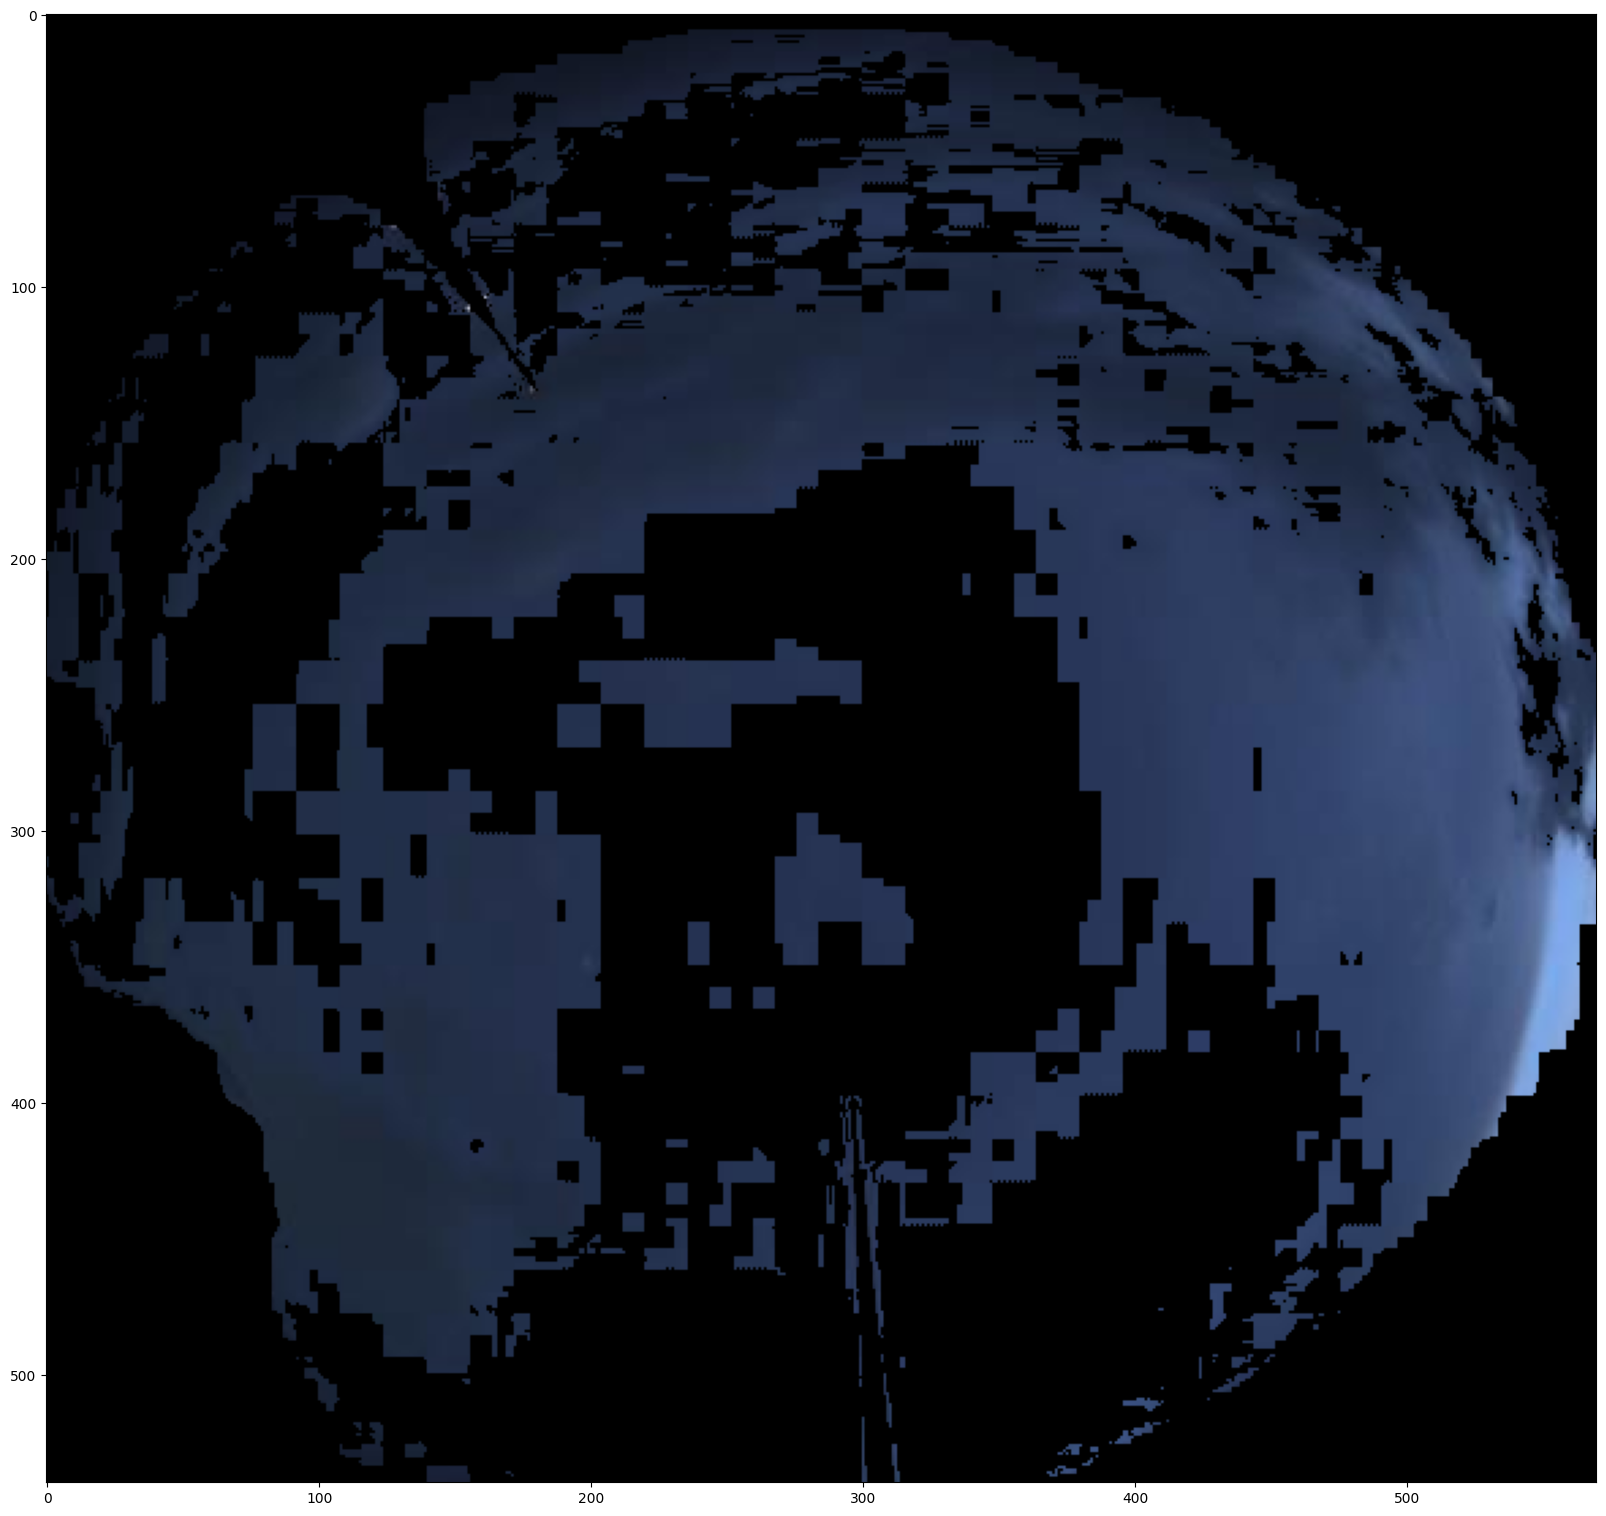

In [259]:
final = cv2.bitwise_and(crop_whole,crop_whole,mask=final_mask)

plt.figure(figsize=(20,20))
plt.imshow(final)

In [237]:
crop_whole = masked[(int(image.shape[0]/2)-270):int((image.shape[0]/2)+270),int((image.shape[1]/2)-290):int((image.shape[1]/2)+280)]
crop_glcm = final

mask_pred = cv2.resize(final,(125,125))
mask_pred = tf.expand_dims(mask_pred, axis=0)

predict_sky = model_pred.predict(mask_pred)[0]
np.asarray(predict_sky)

1/1 [==============================] - 0s 33ms/step


array([0.00131928, 0.41093665, 0.03297989, 0.676486  , 0.00670946],
      dtype=float32)

In [238]:
cloud_pixel = cv2.countNonZero(cv2.cvtColor(final,cv2.COLOR_RGB2GRAY))
whole = cv2.countNonZero(cv2.cvtColor(masked,cv2.COLOR_RGB2GRAY))

coverage = cloud_pixel/whole

def skyPredict(arg):
    if arg == 1:
        return str("Blue sky")
    if arg == 2:
        return str("Medium cloud")
    if arg == 3:
        return str("Dark cloud")
    if arg == 4:
        return str("White cloud")
    if arg == 5:
        return str("Light cloud")

print(f"cloud percentage :{coverage*100} % , cloud status : {skyPredict(np.argmax(predict_sky)+1)} ")

cloud percentage :40.781400177627816 % , cloud status : White cloud 


In [67]:
from skimage.feature import graycomatrix, graycoprops
from skimage import data

final_gray = cv2.cvtColor(crop_glcm,cv2.COLOR_RGB2GRAY)

distance = [2,3]
angle = [0]

In [68]:
glcm = graycomatrix(final_gray,distances=distance,angles=angle,levels=256)

In [69]:
features = {
        'contrast': graycoprops(glcm, 'contrast').flatten(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').flatten(),
        'homogeneity': graycoprops(glcm, 'homogeneity').flatten(),
        'energy': graycoprops(glcm, 'energy').flatten(),
        'correlation': graycoprops(glcm, 'correlation').flatten(),
        'ASM': graycoprops(glcm, 'ASM').flatten()
    }

Contrast: [21.93306599 32.7913319 ]
Dissimilarity: [0.19909364 0.27453132]
Homogeneity: [0.99647528 0.9961376 ]
Energy: [0.99599963 0.99576069]
Correlation: [0.91679739 0.87582512]
Asm: [0.99201527 0.99153934]


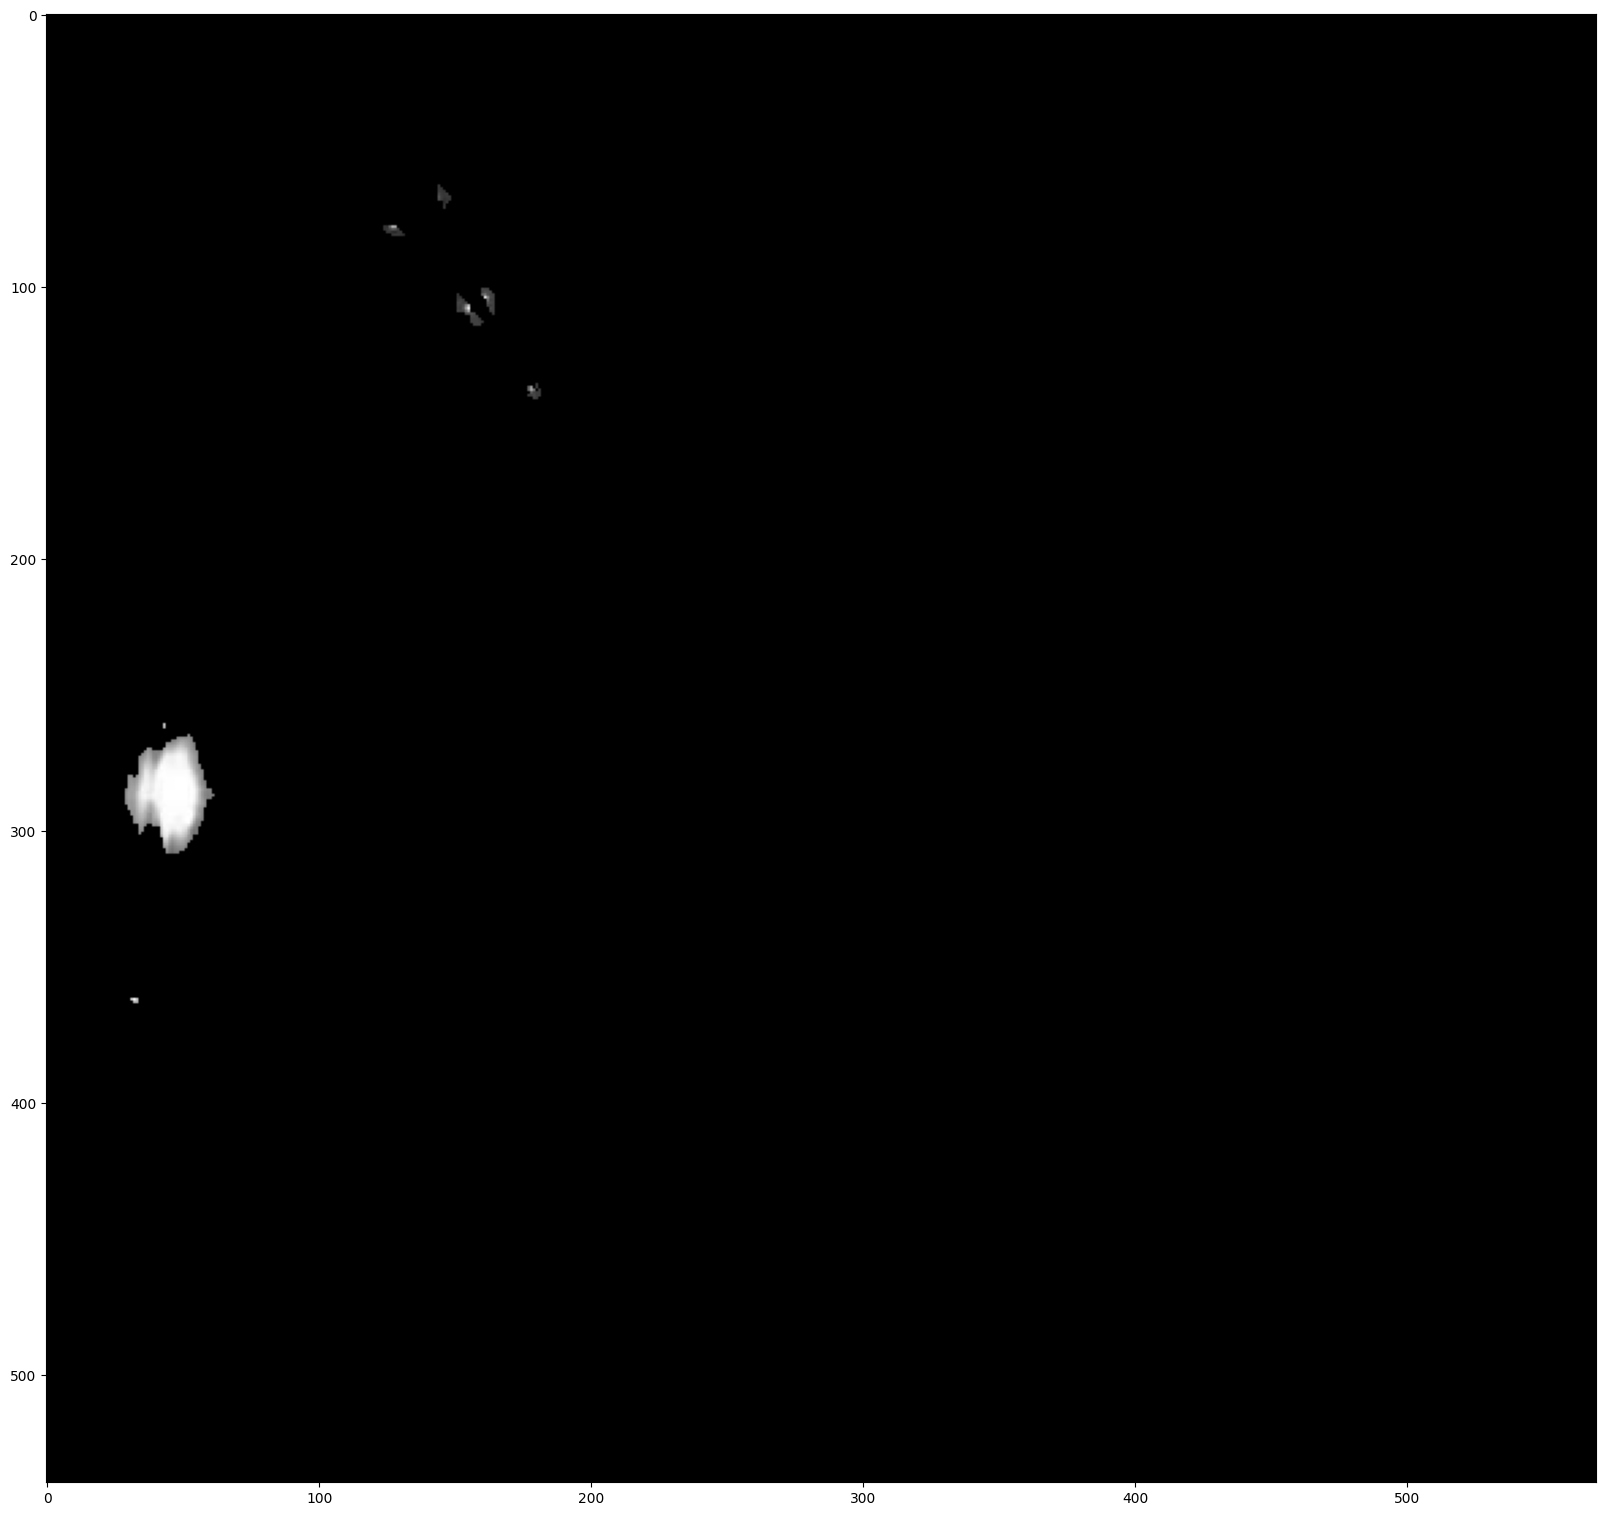

In [70]:
for feature_name, feature_values in features.items():
    print(f"{feature_name.capitalize()}: {feature_values}")

plt.figure(figsize=(20,20))
plt.imshow(final_gray,cmap='gray')


In [260]:
def RBratio(input):
    final = []
    value= []
    e = 1e-11
    threshold = computeQuatile(input)
    for i in input:
        R,_,B = cv2.split(i)
        B = B+e
        intensity = np.mean(i)
        if intensity <= threshold:
            ratio = (R/B)*intensity/8
            ratio = cv2.convertScaleAbs(ratio)
            final_mask = cv2.threshold(ratio, intensity/10, 255, cv2.THRESH_BINARY)[1]
        if np.mean(crop_whole) < threshold-5:
            ratio = (R/B)*np.mean(crop_whole)/8
            ratio_1 = cv2.convertScaleAbs(ratio)
            _,final_mask = cv2.threshold(ratio_1, np.mean(crop_whole)/16, 255, cv2.THRESH_BINARY)  
        else:
            ratio = (R/B)*intensity/10
            ratio = cv2.convertScaleAbs(ratio)
            final_mask = cv2.threshold(ratio, intensity/20, 255, cv2.THRESH_BINARY)[1]
        masked = cv2.bitwise_and(i,i,mask=final_mask)
        masked_gray = cv2.cvtColor(masked,cv2.COLOR_RGB2GRAY)
        final.append(masked_gray)
        value.append(intensity)
    return final,value
def computeQuatile(image):
    inten = []
    for i in image:
        inten.append(np.mean(i))
    return np.percentile(inten,25)

def load_images_and_preprocess(path:str,mask):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        img = img[(int(img.shape[0]/2)-270):int((img.shape[0]/2)+270),int((img.shape[1]/2)-290):int((img.shape[1]/2)+280)]
        img = cv2.bitwise_and(img,img,mask=mask)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(img)
        filename = [f"img_{i+1}.jpg" for i in range(len(images))] 
    return images,filename

def getDataframe(property:list,gray_level,index:list,intensity):
    dataset = {
        prop : [] for prop in property
    }
    for i in gray_level:
        for prop in property:
            dataset[prop].append(graycoprops(i, prop).flatten()[0])
    dataframe = pd.DataFrame(data=dataset,index=(index))
    if intensity:
        dataframe['intensity'] = [np.mean(i) for i in intensity]
    return dataframe
def computeGlcm(image:list,distance,angle):
    glcm = []
    for i in image:
        gray = graycomatrix(i,distance,angle)
        glcm.append(gray)
    return glcm



In [261]:
properties = ['contrast',
            'dissimilarity',
            'homogeneity',
            'energy',
            'correlation',
            'ASM']

mask_path = r'mask_delete_5.png'
mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
mask = mask[(int(mask.shape[0]/2)-270):int((mask.shape[0]/2)+270),int((mask.shape[1]/2)-290):int((mask.shape[1]/2)+280)]

images,filename = load_images_and_preprocess(r'All_sky_camera_Astropark_Chaingmai\2024-06-20',mask=mask)
masked,value = RBratio(input=images)

In [262]:
glcm = computeGlcm(image=masked,distance=[2],angle=[0])
df = getDataframe(properties,glcm,filename,intensity=images)

94.37470218756768


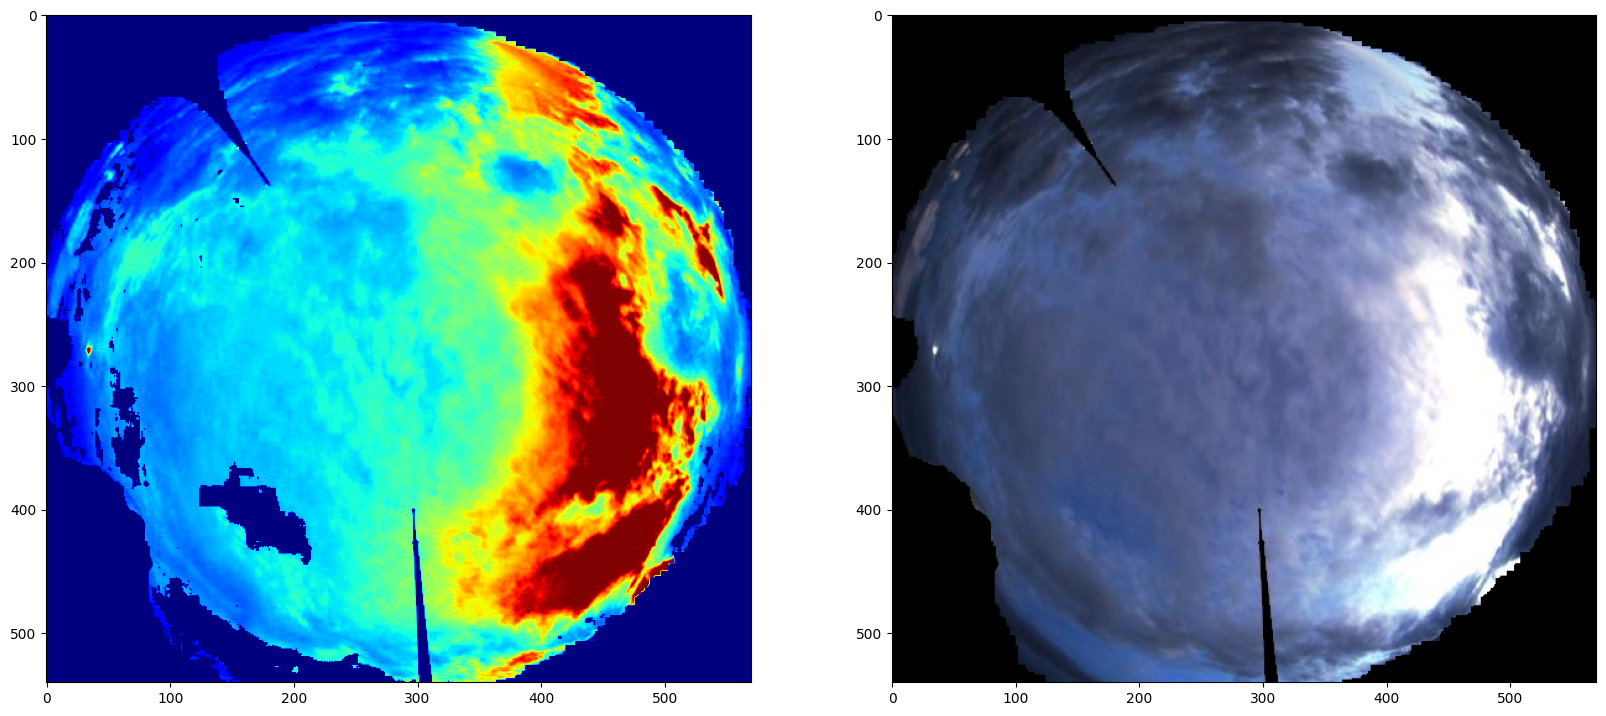

In [277]:
im = 438
print(value[im])
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(masked[im],cmap='jet')
plt.subplot(1,2,2)
plt.imshow(images[im])

In [271]:
print(computeQuatile(image=images))

50.262818388564


In [278]:
df.to_csv('GLCM_feature_ALL_sky_cloud.csv')

<Axes: >

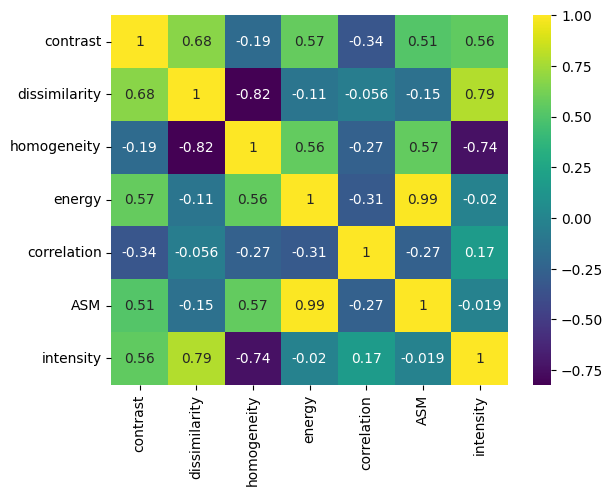

In [282]:
sns.heatmap(df.corr(),annot=True,cmap='viridis')